<a href="https://colab.research.google.com/github/Raffo99/BDAProject/blob/main/Notebook_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Twitter is a social network allowing the sharing of information in the form of tweets, which are short messages.

The particularity of twitter is to be able to attach keywords (hashtag) to this message, which can then be taken over by other users, or to be able to take over a message and spread it on its own account, we talk about retweet. 

With the growth of the number of users, we can see that some messages and/or information can have a strong echo with a societal impact.

The dataset I chose is compose of data that represent ≃500.000 and more tweets with indicators of evolution on certain criteria such as number of discussion created, level of attention, number of authors per keyword, ... (it can be found [here](https://archive.ics.uci.edu/ml/datasets/Buzz+in+social+media+#)).

There is no precise definition of the notion of Buzz, so we will define **Buzz** as the rapid increase of activity (Tweets, Retweets) over a short period of time.

This growth can be mathematized as a peak, as in the case of an exceptional event (a soccer goal, an earthquake, ...), or as a regular growth (an exceptional music group, ...).

The dataset is focused on the determination of these 2 types of events carried out on an observation of 7 periods of time, with 2 days between each, so in reality the dataset has only 11 features measured in 7 different time (7x11 = 77), plus the last one that is the Buzz column, which indicates the value of buzziness of the row, with a number.

The 11 differents features are these:
- **NCD**    : Number of created discussions
- **AI**      : Author increase
- **AS (NA)**  : Attention Level (measured with number of authors)
- **AS (NAC)** : Attention Level (measured with number of contributions)
- **BL**      : Burstiness level
- **NAC**     : Number of Atomic Containers
- **CS**      : Contribution Sparseness
- **AT**      : Author iteration
- **NA**      : Number of Authors
- **ADL**     : Average Discussions Length
- **NAD**     : Average Discussions Length

For more on the dataset and his features [this is the original paper](https://hal.science/hal-00881395/document) for the creation and test of some machine learning algorithms.
<hr>

# Process
I followed the preprocessing pipeline, choose three regression algorithms and three classification algorithms from [this github repository](https://github.com/nilabja9/TwitterBuzzML), for transpose them in Spark with the use of the libary PySpark, and finally compare the results.

The code I wrote was then executed with Spark and Hadoop in a Vagrant environment with two virtual machines, one as a master and one as a worker.

However, for the classification task, it uses a slightly different dataset from the one used for the regression task, because in order to perform a classification, the last column (Buzz) was trashold with a value (500) so now the latter is a binary value column with only this possible values:
- 0, if the row is not a buzz keyword (< 500)
- 1, if the row is a buzz keyword (≥ 500)

Also the latter, has a few number of example, only ≃140.000, but same number of features (78).

Between the algorithms for the regression in the repo, I chose to implement:
- Linear Regression
- Ridge Regression
- Lasso Regression

The alogrithms for the classification I chose to implement with PySpark:
- Logistic Regression
- Linear SVC
- Decision Tree


<hr>

# Important install and import for the project

In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 8.3 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=2df8b4070618c47d4374f163d93b0f1eb894803215575d5d380c7491d2d3f4e3
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [ ]:
import pandas as pd
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType, DecimalType
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression, LinearSVC, DecisionTreeClassifier
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import PolynomialExpansion
from prettytable import PrettyTable
import numpy as np

In [ ]:
# Inizialize new spark session
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

<hr>

# Regression Task

## Dataset Preprocess

In [ ]:
# Definition of the schema for the dataset
twitter_schema = StructType([StructField("NCD_" + str(index), IntegerType(), True) for index in range(7)] +
    [StructField("AI_" + str(index), IntegerType(), True) for index in range(7)] +
    [StructField("AS(NA)_" + str(index), DoubleType(), True) for index in range(7)] +
    [StructField("BL_" + str(index), DoubleType(), True) for index in range(7)] +
    [StructField("NAC_" + str(index), IntegerType(), True) for index in range(7)] +
    [StructField("AS(NAC)_" + str(index), DoubleType(), True) for index in range(7)] +
    [StructField("CS_" + str(index), DoubleType(), True) for index in range(7)] +
    [StructField("AT_" + str(index), DoubleType(), True) for index in range(7)] +
    [StructField("NA_" + str(index), IntegerType(), True) for index in range(7)] +
    [StructField("ADL_" + str(index), DoubleType(), True) for index in range(7)] +
    [StructField("NAD_" + str(index), IntegerType(), True) for index in range(7)] +
    [StructField("Buzz", DoubleType(), True)]
    )

# Using the previously defined schema, read the dataset from the csv file
twitter = spark.read.format("csv")\
  .schema(twitter_schema)\
  .option("sep", ",")\
  .option("path","/content/twitter_regression.csv").load()

In [ ]:
twitter.show()

+-----+-----+-----+-----+-----+-----+-----+----+----+----+----+----+----+----+--------+--------+--------+--------+--------+--------+--------+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+---------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+
|NCD_0|NCD_1|NCD_2|NCD_3|NCD_4|NCD_5|NCD_6|AI_0|AI_1|AI_2|AI_3|AI_4|AI_5|AI_6|AS(NA)_0|AS(NA)_1|AS(NA)_2|AS(NA)_3|AS(NA)_4|AS(NA)_5|AS(NA)_6|BL_0|BL_1|BL_2|BL_3|BL_4|BL_5|BL_6|NAC_0|NAC_1|NAC_2|NAC_3|NAC_4|NAC_5|NAC_6|AS(NAC)_0|AS(NAC)_1|AS(NAC)_2|AS(NAC)_3|AS(NAC)_4|AS(NAC)_5|AS(NAC)_6|CS_0|CS_1|CS_2|CS_3|CS_4|CS_5|CS_6|AT_0|AT_1|AT_2|AT_3|AT_4|AT_5|AT_6|NA_0|NA_1|NA_2|NA_3|NA_4|NA_5|NA_6|ADL_0|ADL_1|ADL_2|ADL_3|ADL_4|ADL_5|ADL_6|NAD_0|NAD_1|NAD_2|NAD_3|NAD_4|NAD_5|NAD_6|Buzz|
+-----+-----+-----+-----+-----+---

In [ ]:
twitter.describe().show()

+-------+------------------+------------------+-----------------+-----------------+------------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+------------------+------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+-------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-----------------+------------------+-----------------+-----------------+------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+------------------+------------------+------------------+-------------------+-------------------+------------------+----------------

Next, we prepare the dataset for being used in a Spark environment, using the Vector Assembler in order to merge multiple columns into a vector column, because for the mllib of pyspark, we need the features of our dataset to be in a single vector column, usually named 'features'.

In [ ]:
vec_assembler = VectorAssembler(inputCols=twitter.columns[:-1], outputCol="features")
stages = [vec_assembler]
pipeline = Pipeline(stages = stages)
pipeline_mod = pipeline.fit(twitter)
twitter_transfd = pipeline_mod.transform(twitter)
inp_twitter = twitter_transfd.select(['features', 'Buzz'])

In [ ]:
inp_twitter.show()

+--------------------+----+
|            features|Buzz|
+--------------------+----+
|(77,[1,4,5,6,8,11...| 0.0|
|(77,[0,1,6,7,8,13...| 0.5|
|(77,[0,5,6,7,12,1...| 0.0|
|(77,[0,3,6,7,10,1...| 2.5|
|(77,[1,4,5,6,8,11...| 0.5|
|(77,[0,3,4,5,7,10...| 1.0|
|(77,[0,4,6,7,11,1...| 0.0|
|(77,[1,5,6,8,12,1...| 2.0|
|(77,[0,4,5,6,7,11...| 1.0|
|[0.0,1.0,1.0,2.0,...| 0.5|
|[1.0,1.0,2.0,2.0,...| 0.5|
|[0.0,1.0,1.0,1.0,...| 0.0|
|(77,[1,2,6,8,9,13...|17.5|
|(77,[0,1,5,6,7,8,...| 0.5|
|(77,[0,4,5,6,7,11...| 6.5|
|[1.0,0.0,13.0,4.0...|28.5|
|[0.0,13.0,4.0,11....|23.5|
|[13.0,4.0,11.0,9....|12.0|
|[4.0,11.0,9.0,10....| 8.0|
|[11.0,9.0,10.0,18...| 1.0|
+--------------------+----+
only showing top 20 rows



Next, we take the 10% of the dataset in order to do Cross Validation for compare the results with the original repository.

In [ ]:
_, cv_set = inp_twitter.randomSplit([0.9, 0.1], seed=0)

And also split the dataset in a 75%-25% for the train and test set.

This proportion (0.75-0.25) is the default setting for the train_test_splitting function of sklearn used in the repository.

In [ ]:
train_twitter, test_twitter = inp_twitter.randomSplit([0.75, 0.25], seed=0)

Initiate the Regression Evaluator object used to evaluate the predictions of the machine learning models, giving as input the name of the column with the predictions ("prediction"), and the column with the labels ("Buzz").

The metric we focus our attention on is the R2, because it was used in the github repository and will be needed for comparison. 

(It is the default score function for the regression class in sklearn)

In [ ]:
regr_eval = RegressionEvaluator(predictionCol="prediction", labelCol="Buzz", metricName="r2")

## Linear Regression

In the PySpark library, there is no distinction between different regressions; there is only one class, named *LinearRegression*, which is a **generalized linear regression**. 

The latter has a parameter named **elasticNetParam** that
- if it is equal to zero, will give a Ridge Regression
- if it is equal to one, will give a Lasso Regression
- if it is in $(0, 1)$, will give a regular Linear Regression

So I initialized three different objects with different elasticNetParam in order to use different regressions.

In [ ]:
# Linear Regression
linear_regression = LinearRegression(featuresCol='features', labelCol='Buzz', elasticNetParam=0.1, regParam=0.1)

First of all we do the cross validation on 10% of the dataset, with 5-folds, likewise in the original repository.

In [ ]:
cross_val = CrossValidator(estimator=linear_regression, 
                           evaluator=regr_eval,
                           estimatorParamMaps=ParamGridBuilder().build(),
                           numFolds=5)
cross_val_model = cross_val.fit(cv_set)

At the end we save the average of the $R^2$s for every fold of the cross validation.

In [ ]:
lr_cv_avg = cross_val_model.avgMetrics[0]
print("Cross Validation Avg R2: ", lr_cv_avg)

Cross Validation Avg R2:  0.9267814089218025


Finally we fit the model on all the train set (75% of the whole dataset).

In [ ]:
linear_regression = LinearRegression(featuresCol='features', labelCol='Buzz', elasticNetParam=0.1, regParam=0.1)
lr_model = linear_regression.fit(train_twitter)

Next on, we predict the Buzz column values on the train and test split in order to evaluate them and get the $R^2$ scores.

In [ ]:
lr_preds_train = lr_model.transform(train_twitter)
lr_preds_test = lr_model.transform(test_twitter)

lr_result_train = regr_eval.evaluate(lr_preds_train)
lr_result_test = regr_eval.evaluate(lr_preds_test)

print("R2 (train):", lr_result_train)
print("R2 (test):", lr_result_test)

R2 (train): 0.9421070438953077
R2 (test): 0.900321722959547


## Ridge Regression

We do the same as for the linear regression, but the class LinearRegression will be initiated with the elasticNetParam set to 0, so we will obtain a Ridge Regression. 

In [ ]:
# Ridge Regression
ridge_regression = LinearRegression(featuresCol='features', labelCol='Buzz', elasticNetParam=0, regParam=0.1)

In [ ]:
# Cross Validation on cv set
cross_val = CrossValidator(estimator=ridge_regression, 
                           evaluator=regr_eval,
                           estimatorParamMaps=ParamGridBuilder().build(),
                           numFolds=5)
cross_val_model = cross_val.fit(cv_set)

In [ ]:
# Save and print of the average of R2 scores in folds
rr_cv_avg = cross_val_model.avgMetrics[0]
print("Cross Validation Avg R2: ", rr_cv_avg)

Cross Validation Avg R2:  0.9266555935934037


In [ ]:
# Fit of the model on the train set
ridge_regression = LinearRegression(featuresCol='features', labelCol='Buzz', elasticNetParam=0, regParam=0.1)
rr_model = ridge_regression.fit(train_twitter)

In [ ]:
# Prediction and evaluation on the train and test set with R2 metric
rr_preds_train = rr_model.transform(train_twitter)
rr_preds_test = rr_model.transform(test_twitter)

rr_result_train = regr_eval.evaluate(rr_preds_train)
rr_result_test = regr_eval.evaluate(rr_preds_test)

print("R2 (train):", rr_result_train)
print("R2 (test):", rr_result_test)

R2 (train): 0.9456776157816156
R2 (test): 0.8984758622238314


## Lasso Regression

We do the same as for the linear regression and ridge regression, but the class LinearRegression will be initiated with the elasticNetParam set to 1, so we will obtain a Lasso Regression.

In [ ]:
# Lasso Regression
lasso_regression = LinearRegression(featuresCol='features', labelCol='Buzz', elasticNetParam=1, regParam=0.1)

In [ ]:
# Cross Validation on cv set
cross_val = CrossValidator(estimator=lasso_regression, 
                           evaluator=regr_eval,
                           estimatorParamMaps=ParamGridBuilder().build(),
                           numFolds=5)
cross_val_model = cross_val.fit(cv_set)

In [ ]:
# Save and print of the average of R2 scores in folds
lasso_cv_avg = cross_val_model.avgMetrics[0]
print("Cross Validation Avg R2: ", lasso_cv_avg)

Cross Validation Avg R2:  0.9302708553258313


In [ ]:
# Fit of the model on the train set
lasso_regression = LinearRegression(featuresCol='features', labelCol='Buzz', elasticNetParam=1, regParam=0.1)
lasso_model = lasso_regression.fit(train_twitter)

In [ ]:
# Prediction and evaluation on the train and test set with R2 metric
lasso_preds_train = lasso_model.transform(train_twitter)
lasso_preds_test = lasso_model.transform(test_twitter)

lasso_result_train = regr_eval.evaluate(lasso_preds_train)
lasso_result_test = regr_eval.evaluate(lasso_preds_test)

print("R2 (train):", lasso_result_train)
print("R2 (test):", lasso_result_test)

R2 (train): 0.9433960367945713
R2 (test): 0.901514351231929


<hr>

# Classification Task


## Dataset Preprocess

For the classification task, there is another dataset with the only difference that the last column named "Buzz" has only two possibile values:
- 0, if the row is no Buzz tweet
- 1, if the row is a Buzz tweet

These values has been generated by assign the examples with ≥ 500 value for Buzz to the positive class (1), otherwise to the negative (0).

This dataset is unbalanced because only the 19% of the examples are negative, the other 81% is compose of positive examples.

As in the regression task, I first define the schema of the dataset before reading it from the csv file, this time the only difference is in the last column, which is of type Integer.

In [ ]:
twitter_schema = StructType([StructField("NCD_" + str(index), IntegerType(), True) for index in range(7)] +
    [StructField("AI_" + str(index), IntegerType(), True) for index in range(7)] +
    [StructField("AS(NA)_" + str(index), DoubleType(), True) for index in range(7)] +
    [StructField("BL_" + str(index), DoubleType(), True) for index in range(7)] +
    [StructField("NAC_" + str(index), IntegerType(), True) for index in range(7)] +
    [StructField("AS(NAC)_" + str(index), DoubleType(), True) for index in range(7)] +
    [StructField("CS_" + str(index), DoubleType(), True) for index in range(7)] +
    [StructField("AT_" + str(index), DoubleType(), True) for index in range(7)] +
    [StructField("NA_" + str(index), IntegerType(), True) for index in range(7)] +
    [StructField("ADL_" + str(index), DoubleType(), True) for index in range(7)] +
    [StructField("NAD_" + str(index), IntegerType(), True) for index in range(7)] +
    [StructField("Buzz", IntegerType(), True)]
    )

twitter_classification = spark.read.format("csv") \
  .schema(twitter_schema) \
  .option("sep", ",") \
  .option("path","/content/twitter_classification.csv").load()

Next, we use the vector assembler as in the regression task, in order to create a unique vector column for the features of the dataset.

In [ ]:
vec_assembler = VectorAssembler(inputCols=twitter_classification.columns[:-1], outputCol="features")
stages = [vec_assembler]
pipeline = Pipeline(stages = stages)
pipeline_mod = pipeline.fit(twitter_classification)
twitter_transfd = pipeline_mod.transform(twitter_classification)
inp_twitter_classification = twitter_transfd.select(['features', 'Buzz'])

In [ ]:
inp_twitter_classification.show()

+--------------------+----+
|            features|Buzz|
+--------------------+----+
|[889.0,939.0,960....|   1|
|[542.0,473.0,504....|   1|
|[92.0,99.0,196.0,...|   0|
|[90.0,87.0,92.0,3...|   1|
|[169.0,98.0,101.0...|   1|
|[775.0,765.0,935....|   1|
|[469.0,1092.0,332...|   1|
|[818.0,693.0,756....|   1|
|[832.0,628.0,898....|   1|
|[920.0,1071.0,833...|   1|
|[849.0,798.0,863....|   1|
|[847.0,649.0,687....|   1|
|[870.0,950.0,1041...|   1|
|[699.0,704.0,903....|   1|
|[683.0,558.0,882....|   1|
|[780.0,716.0,1006...|   1|
|[860.0,85.0,0.0,7...|   1|
|[803.0,924.0,200....|   1|
|[810.0,970.0,675....|   1|
|[792.0,826.0,1017...|   1|
+--------------------+----+
only showing top 20 rows



Next, we proceed to create the splits for train and test as before, so 75% for the train and 25% for the test.
We don't need the cross validation split with the 10% of the dataset, because in the original repository it is not used in the classification task, so I woul'd have something to compare to.


In [ ]:
train_twitter_classification, test_twitter_classification = inp_twitter_classification.randomSplit([0.75, 0.25], seed=0)

In this case we use the **BinaryClassificationEvaluator** for evaluate the results of the models, using the **areaUnderROC** as metric, that is the one used in the original github repository.

In [ ]:
classification_eval = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="Buzz", metricName="areaUnderROC")

## Logistic Regression


The first alogrithm is the logistic regression, the class we use is LogisticRegression and has the same parameters as the LinearRegression, we only pass the name of the featurs column and the labels column.

In [10]:
# Initiate of logistic regression and fit on the train set
logistic_regression = LogisticRegression(featuresCol='features', labelCol='Buzz', maxIter=1000)
logistic_regression_model = logistic_regression.fit(train_twitter_classification)

In [11]:
# Prediction and evaluation on the train and test set with AuROC metric
logistic_regression_preds_train = logistic_regression_model.transform(train_twitter_classification)
logistic_regression_preds_test  = logistic_regression_model.transform(test_twitter_classification)

logistic_regression_result_train = classification_eval.evaluate(logistic_regression_preds_train)
logistic_regression_result_test = classification_eval.evaluate(logistic_regression_preds_test)

print("AuROC (train):", logistic_regression_result_train)
print("AuROC (test):", logistic_regression_result_test)

AuROC (train): 0.9380933951716683
AuROC (test): 0.9376039531310626


## Linear SVC

In [12]:
# Initiate of Linear SVC and fit on the train set
svc = LinearSVC(featuresCol='features', labelCol='Buzz', maxIter=1000)
svc_model = svc.fit(train_twitter_classification)

In [14]:
# Prediction and evaluation on the train and test set with AuROC metric
svc_preds_train = svc_model.transform(train_twitter_classification)
svc_preds_test  = svc_model.transform(test_twitter_classification)

svc_result_train = classification_eval.evaluate(svc_preds_train)
svc_result_test = classification_eval.evaluate(svc_preds_test)

print("AuROC (train):", svc_result_train)
print("AuROC (test):", svc_result_test)

AuROC (train): 0.939826570898081
AuROC (test): 0.9396275221297739


## Decision Tree

In [20]:
# Initiate of Decision Tree and fit on the train set
decision_tree = DecisionTreeClassifier(featuresCol='features', labelCol='Buzz')
decision_tree_model = decision_tree.fit(train_twitter_classification)

In [21]:
# Prediction and evaluation on the train and test set with AuROC metric
dt_preds_train = decision_tree_model.transform(train_twitter_classification)
dt_preds_test  = decision_tree_model.transform(test_twitter_classification)

dt_result_train = classification_eval.evaluate(dt_preds_train)
dt_result_test = classification_eval.evaluate(dt_preds_test)

print("AuROC (train):", dt_result_train)
print("AuROC (test):", dt_result_test)

AuROC (train): 0.9374930635126814
AuROC (test): 0.9327858106129399


<hr>

# Results and Conclusion

## Results on Colab

In [ ]:
regression_results = PrettyTable()
regression_results.field_names = ["Model", "Train Result", "Test Result", "Cross Validation Avg"]
regression_results.add_row(["Linear Regression", lr_result_train, lr_result_test, lr_cv_avg])
regression_results.add_row(["Ridge Regression", rr_result_train, rr_result_test, rr_cv_avg])
regression_results.add_row(["Lasso Regression", lasso_result_train, lasso_result_test, lasso_cv_avg])

In [ ]:
print(regression_results)

+-------------------+--------------------+--------------------+----------------------+
|       Model       |    Train Result    |    Test Result     | Cross Validation Avg |
+-------------------+--------------------+--------------------+----------------------+
| Linear Regression | 0.9421070438953077 | 0.900321722959547  |  0.9267814089218025  |
|  Ridge Regression | 0.9456776157816156 | 0.8984758622238314 |  0.9266555935934037  |
|  Lasso Regression | 0.9433960367945713 | 0.901514351231929  |  0.9302708553258313  |
+-------------------+--------------------+--------------------+----------------------+


In [22]:
classification_results = PrettyTable()
classification_results.field_names = ["Model", "Train Result", "Test Result"]
classification_results.add_row(["Logistic Regression", logistic_regression_result_train, logistic_regression_result_test])
classification_results.add_row(["Linear SVC", svc_result_train, svc_result_test])
classification_results.add_row(["Decision Tree", dt_result_train, dt_result_test])

In [23]:
print(classification_results)

+---------------------+--------------------+--------------------+
|        Model        |    Train Result    |    Test Result     |
+---------------------+--------------------+--------------------+
| Logistic Regression | 0.9380933951716683 | 0.9376039531310626 |
|      Linear SVC     | 0.939826570898081  | 0.9396275221297739 |
|    Decision Tree    | 0.9374930635126814 | 0.9327858106129399 |
+---------------------+--------------------+--------------------+


## Comparison of Vagrant Results and the Original Repository

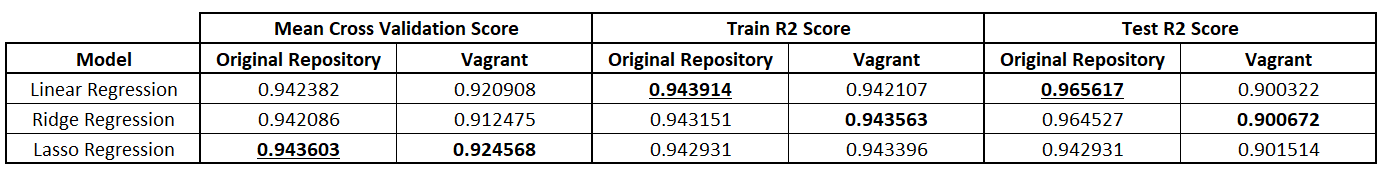

First of all, we can notice that the results are all very similary for the train splits and also, for the mean cross validation scores the loss is very low.

Where we lose much respect the original work is the test split, with a drop of 0.06 points in the linear and ridge regression.

This could be because the models can't generalize as well as in the original work; some possible reasons would be that:
- The function used to split the dataset is different; they both use the same seed, but one is from Sklearn and the other is from PySpark, so in the original work there would be a very good train split that generalized the data better and gave a good score on the test set
- Even for the ML algorithms and models we use PySpark instead of Sklearn, I tried to report some of the parameters of the original work in these classes, but sometimes there is no corresponding PySpark class or the parameter doesn't have the same effect as in the original work, worsening the results.

Overall, for our results, and even in the original work, all the models have similar $R^2$ scores on every split, maybe the best is the Ridge Regression with a small gain in the test set and, so, generalization of the data.



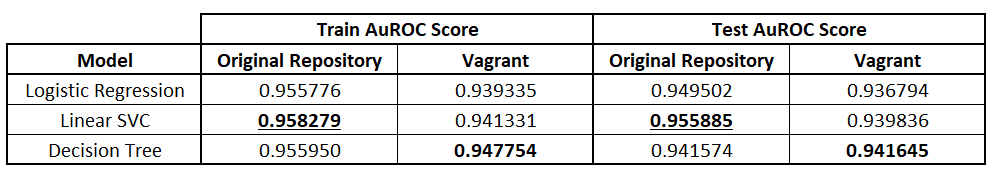

The same can be said for the classification task, where we some points compared to the original work, in the train and test set.

At the end we can say that, we didn't reach the same scores of the original work, but we have realitivy good performances in almost all configurations.